**ПОСТРОЕНИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ,  
ОПРЕДЕЛЯЮЩЕЙ ТРЕБУЕМЫЕ ОТ ПРЕТЕНДЕНТА НАВЫКИ В ТЕКСТЕ ОБЪЯВЛЕНИЯ НА ВКАНСИЮ** 
  
Аргентов С.Г. 22.03.23  
https://argentov.pro

_________  

<h1>СОДЕРЖАНИЕ<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Загрузка:-библиотек,-разработанных-функций,-данных" data-toc-modified-id="1.-Загрузка:-библиотек,-разработанных-функций,-данных-1">1. Загрузка: библиотек, разработанных функций, данных</a></span></li><li><span><a href="#2.-Подготовка-данных-для-обучения-модели-нейросети" data-toc-modified-id="2.-Подготовка-данных-для-обучения-модели-нейросети-2">2. Подготовка данных для обучения модели нейросети</a></span><ul class="toc-item"><li><span><a href="#2.1.-Исходные-условия-для-поиска-навыков-в-тексте-объявлений" data-toc-modified-id="2.1.-Исходные-условия-для-поиска-навыков-в-тексте-объявлений-2.1">2.1. Исходные условия для поиска навыков в тексте объявлений</a></span></li><li><span><a href="#2.2.-Преобразование-признаков-таргета-в-векторы" data-toc-modified-id="2.2.-Преобразование-признаков-таргета-в-векторы-2.2">2.2. Преобразование признаков таргета в векторы</a></span></li><li><span><a href="#2.3.-Преобразование-исходных-текстов-объявлений-в-векторы" data-toc-modified-id="2.3.-Преобразование-исходных-текстов-объявлений-в-векторы-2.3">2.3. Преобразование исходных текстов объявлений в векторы</a></span></li></ul></li><li><span><a href="#3.-Модель-нейронной-сети-LSTM" data-toc-modified-id="3.-Модель-нейронной-сети-LSTM-3">3. Модель нейронной сети LSTM</a></span><ul class="toc-item"><li><span><a href="#3.1.-Формирование-модели" data-toc-modified-id="3.1.-Формирование-модели-3.1">3.1. Формирование модели</a></span></li><li><span><a href="#3.2.-Обучение-модели" data-toc-modified-id="3.2.-Обучение-модели-3.2">3.2. Обучение модели</a></span></li></ul></li><li><span><a href="#4.-Прогноз-неросетью-данных-о-вакансиях" data-toc-modified-id="4.-Прогноз-неросетью-данных-о-вакансиях-4">4. Прогноз неросетью данных о вакансиях</a></span><ul class="toc-item"><li><span><a href="#4.1.-Оценка-качества-работы-нейронной-сети" data-toc-modified-id="4.1.-Оценка-качества-работы-нейронной-сети-4.1">4.1. Оценка качества работы нейронной сети</a></span></li><li><span><a href="#4.2.-Классификация-навыков,-определённых-моделью" data-toc-modified-id="4.2.-Классификация-навыков,-определённых-моделью-4.2">4.2. Классификация навыков, определённых моделью</a></span></li><li><span><a href="#4.3.-Загрузка-навыков-в-json-файл" data-toc-modified-id="4.3.-Загрузка-навыков-в-json-файл-4.3">4.3. Загрузка навыков в json-файл</a></span></li></ul></li></ul></div>

___________________  

# 1. Загрузка: библиотек, разработанных функций, данных

In [2]:
# Загружаем библиотеки для работы с нейронной сетью
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

In [3]:
# Загружаем библиотеки для обработки и визуализации данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from multiprocessing import Pool, set_start_method

In [4]:
# Загружаем используемые функции
from package220323.preparation import *
from package220323.download import *
from package220323.visualization import *

In [5]:
# Загружаем датасет с исходными данными и разметкой
df = file_load('2023-01-01-2023-01-10.xlsx')

... загружаем файл с данными датасета ...
Источником данных является файл: 023-01-01-2023-01-10.xlsx
Размер файла 1381016 байт
В файле содержится 1 таблица:
  - количество строк: 952
  - количество столбцов: 78


 ____ 

# 2. Подготовка данных для обучения модели нейросети

## 2.1. Исходные условия для поиска навыков в тексте объявлений

In [6]:
# Количесвто выявляемых навыков в тексет объявления
NUMBER_SKILLS = 93 # Приняты первые 93 навыка по популярности (в >1% объявлений)
# Максимальное количество слов, анализируемое в объявлении
NUMDER_WORDS = 12000
# Максимальная длина комментария
MAX_DESCRIPTION_LEN = 120

## 2.2. Преобразование признаков таргета в векторы

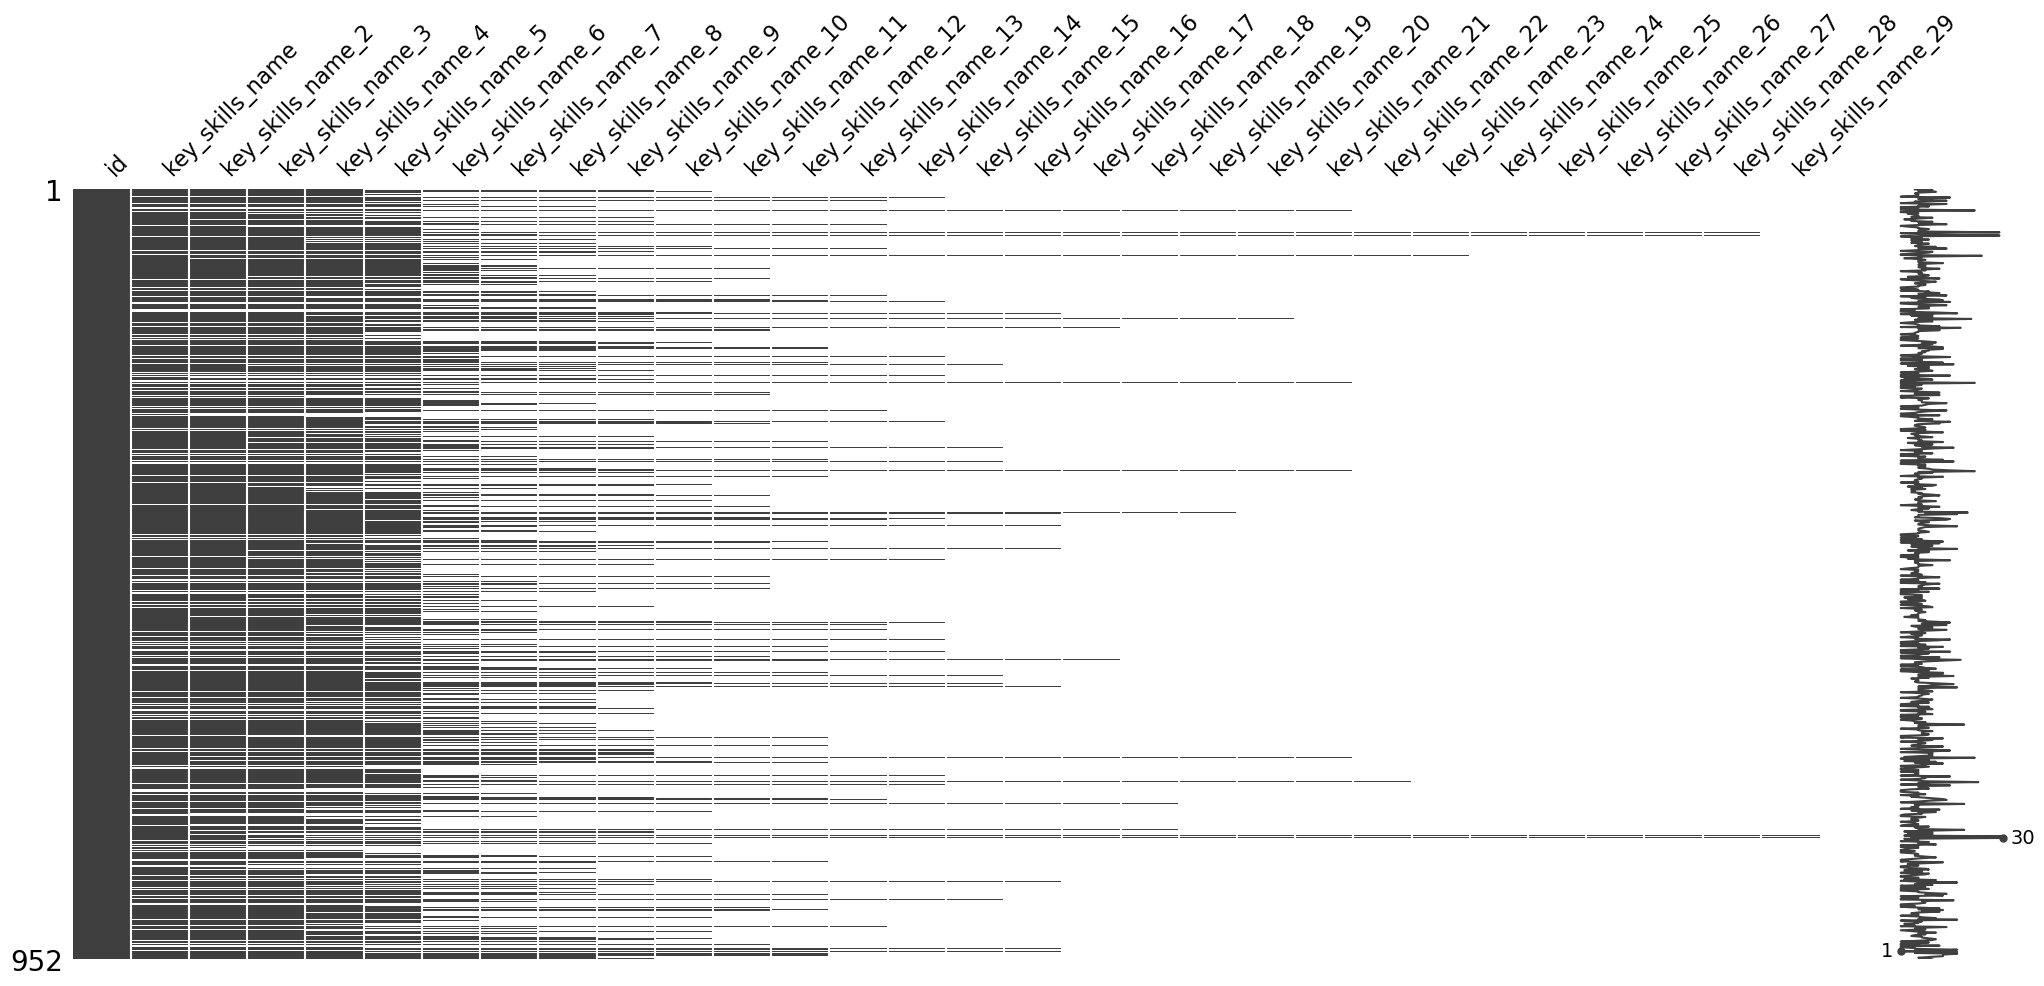

In [7]:
# Сформируем схему разметки таргетов (навыков в объявлении)
# (первым элементом списка оставим 'id' для сохранения размерности датафрейма)
df_skills = labeled_skills(df)

In [8]:
# Удалим записи, в которых пропущена разметка таргетов (навыков в объявлении)
df = df.drop(index=df_skills[1], axis=0)
df_skills_ = df_skills[0].drop(index=df_skills[1], axis=0)

In [9]:
# Сформируем векторы таргетов с максимально востребованными компетенциями
target_vectors = skill_vectors(df, df_skills_, NUMBER_SKILLS)
y = target_vectors[0]

## 2.3. Преобразование исходных текстов объявлений в векторы

In [10]:
# Удаляем из текста html-теги, неалфавитные символы, переводим в нижний регистр,
# лимматизируем слова и исключаем стоп-слова
df['normal_description'] = df.description.apply(lambda x: text_converter(x))

In [11]:
# Создаём токенизатор
tokenizer = Tokenizer(num_words=NUMDER_WORDS)
# Обучаем токенизатор
tokenizer.fit_on_texts(df['normal_description'])
# Преобразуем текст в числовые представления
sequences = tokenizer.texts_to_sequences(df['normal_description'])

In [12]:
# Ограничим длинну описательной части объявления
X = pad_sequences(sequences, maxlen=MAX_DESCRIPTION_LEN)

In [13]:
# Разобъём датасет на тестовый и проверочный
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [14]:
# Запишем индексы тестовой выборки для формирования json-файла
y_test_id = df[['id']].loc[y_test.index]

____  

# 3. Модель нейронной сети LSTM

## 3.1. Формирование модели

In [15]:
# Создаём колбек для фиксации наилучшей модели
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [16]:
# Задаём структуру модели
model_lstm = Sequential()
model_lstm.add(Embedding(NUMDER_WORDS, 128, input_length=MAX_DESCRIPTION_LEN))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(NUMBER_SKILLS*6, return_sequences=True))
model_lstm.add(LSTM(NUMBER_SKILLS*6))
model_lstm.add(Dense(NUMBER_SKILLS, activation='sigmoid'))

2023-03-25 00:10:01.867686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 00:10:01.869248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 00:10:01.870925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
# Компилируем модель
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

## 3.2. Обучение модели

In [18]:
# Обучаем модель
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=7,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/7


2023-03-25 00:10:14.465311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 00:10:14.467100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 00:10:14.468893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.0095 - auc: 0.4999

2023-03-25 00:10:27.129063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 00:10:27.132906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 00:10:27.135565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.27358, saving model to best_model_lstm.h5
1/1 [==============================] - 15s 15s/step - loss: 0.6932 - accuracy: 0.0095 - auc: 0.4999 - val_loss: 0.6902 - val_accuracy: 0.2736 - val_auc: 0.5439
Epoch 2/7
1/1 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.1876 - auc: 0.5364
Epoch 2: val_accuracy improved from 0.27358 to 0.67925, saving model to best_model_lstm.h5
1/1 [==============================] - 12s 12s/step - loss: 0.6902 - accuracy: 0.1876 - auc: 0.5364 - val_loss: 0.6818 - val_accuracy: 0.6792 - val_auc: 0.6292
Epoch 3/7
1/1 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.6912 - auc: 0.6188
Epoch 3: val_accuracy did not improve from 0.67925
1/1 [==============================] - 10s 10s/step - loss: 0.6818 - accuracy: 0.6912 - auc: 0.6188 - val_loss: 0.6191 - val_accuracy: 0.6792 - val_auc: 0.6449
Epoch 4/7
1/1 [==============================] - ETA: 0s - loss: 0.6190 - accur

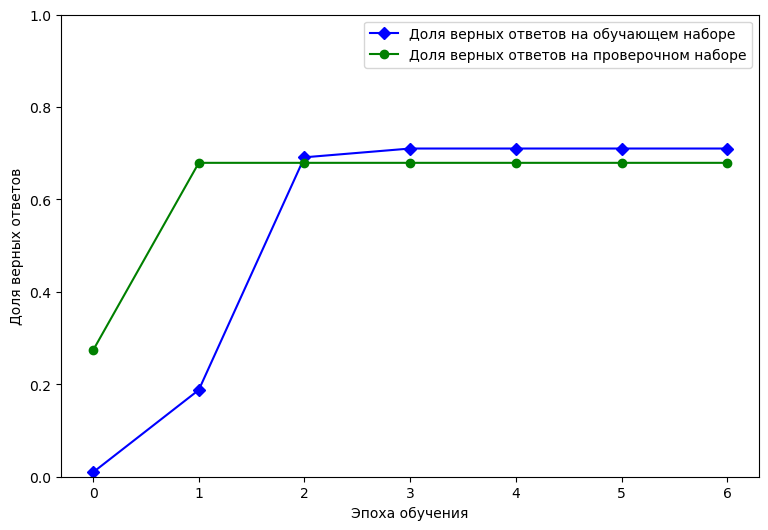

In [19]:
# Построим графики обучения модели
accuracy_graf(history_lstm.history)

# 4. Прогноз неросетью данных о вакансиях

## 4.1. Оценка качества работы нейронной сети

In [20]:
# Загружаем модель
model_lstm.load_weights(model_lstm_save_path)

In [21]:
## Выводим оценку
model_lstm.evaluate(x_test, y_test, verbose=1)

9/9 [==============================] - 5s 496ms/step - loss: 0.6820 - accuracy: 0.7471 - auc: 0.6137


[0.6819724440574646, 0.7471264600753784, 0.6136937141418457]

## 4.2. Классификация навыков, определённых моделью

In [22]:
# Формируем результат работы модели на тестовой выборке
model_result = model_lstm.predict(x_test)

2023-03-25 00:13:07.803295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 00:13:07.804921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 00:13:07.806856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 5s 491ms/step


In [23]:
# Формируем датафрейм для загрузки в json-файл
df_result = pd.DataFrame(data = model_result, columns=target_vectors[2])
res_id = y_test_id.copy()
res_id.reset_index(drop=True, inplace=True)
predict_matrix = pd.concat([res_id, df_result], axis=1)

In [25]:
# Формируем словарь для json-файла
res_skills = {elem: [] for elem in target_vectors[2]}
for i, row in predict_matrix.iterrows():
    for key, skill in row[1:].iteritems():
        if skill > 0.3:
            res_skills[key].append(str(predict_matrix.at[i, 'id']))
res_skills = {elem: res_skills[elem] for elem in res_skills
             if len(res_skills[elem]) != 0}

## 4.3. Загрузка навыков в json-файл

In [26]:
# Формируем json-файл
with open('./Data/result.json', 'w') as f:
    json.dump(res_skills, f)